# Basic Model

In [1]:
%pwd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import utils
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [32]:
base_path = '/home/ubuntu/data/statefarm/imags/' #imags/samples
train_path = base_path + 'train'
val_path = base_path + 'valid'
test_path = base_path + 'test'
weight_path = '/home/ubuntu/data/weights/statefarm/'
sub_path = '/home/ubuntu/fastai_course/neilz/part1/sub/statefarm/'

In [27]:
import vgg16; reload(vgg16)

<module 'vgg16' from 'vgg16.pyc'>

In [28]:
vggm = vgg16.Vgg16()

In [29]:
vggm.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 64, 114, 114)      0         
__________

In [30]:
#Remove dense layers, only keep convolution layers
vggm.model.pop() #dense6
vggm.model.pop() #dropout4
vggm.model.pop() #dense5
vggm.model.pop() #dropout3
vggm.model.pop() #dense4
vggm.compile() 
vggm.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 64, 114, 114)      0         
__________

In [20]:
#Use train data to get convolution results
batch_size = 60
train_batches, train_predictions = vggm.test(train_path, batch_size)
utils.save_array(weight_path + '/statefarm_conv_res', train_predictions)

Found 17943 images belonging to 10 classes.


In [32]:
print(train_predictions[0][:100])

[  0.       0.       0.       0.       0.       0.       1.8962   0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
  35.4123   0.      43.7633   0.       0.       0.       0.       0.       5.4461   0.       0.       0.
   0.       0.       0.      13.4655  11.5091   0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
   0.      16.0039   0.       0.       0.    ]


In [33]:
batch_size = 60
val_batches, val_predictions = vggm.test(val_path, batch_size)
test_batches, test_predictions = vggm.test(test_path, batch_size)
utils.save_array(weight_path + '/statefarm_conv_val', val_predictions)
utils.save_array(weight_path + '/statefarm_conv_test', test_predictions)

Found 4481 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [34]:
print(test_predictions.shape)

(79726, 25088)


In [35]:
mid_train_data = utils.load_array(weight_path + '/statefarm_conv_res')
mid_val_data = utils.load_array(weight_path + '/statefarm_conv_val')
mid_test_data = utils.load_array(weight_path + '/statefarm_conv_test')

In [7]:
print(mid_train_data.shape)

(17943, 25088)


In [93]:
#Construct a new model with just FCBs and using the convoluation results from Vgg16 as input
#I want to overfit the train data first, so I use 2 dense layers total 4096*4096+4096 (bias) parameters without dropout
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
lr = 0.001
statefarm_model = Sequential()
statefarm_model.add(BatchNormalization(axis=1, input_shape=(25088,)))
statefarm_model.add(Dense(256, activation='relu'))
statefarm_model.add(Dropout(0.5)) 
statefarm_model.add(Dense(256, activation='relu'))
statefarm_model.add(Dropout(0.5))
statefarm_model.add(Dense(10, activation='softmax'))
statefarm_model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#If I don't add Dropout layers, I got almost constant train and validation accuracy, 
#which are pretty low, close to zero. Why this is the case? 

In [81]:
val_classes, train_classes, val_labels, train_labels, \
        val_filenames, train_filenames, test_filenames = utils.get_classes(base_path)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [77]:
print(mid_train_data[0])

[ 0.  0.  0. ...,  0.  0.  0.]


In [94]:
statefarm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                2570      
Total params: 6,591,498
Trainable params: 6,541,322
Non-trainable params: 50,176
_____________________________________________________________

In [95]:
from keras import backend as K
K.set_value(statefarm_model.optimizer.lr, 10)
statefarm_model.optimizer.get_config()
statefarm_model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [96]:
from keras.callbacks import ModelCheckpoint
#Need create train batch and validation batch
batch_size = 200

saved_weights_path = weight_path + '/fcn_epoch_{epoch:02d}-valloss_{val_loss:.2f}.hdf5'
mcp = ModelCheckpoint(saved_weights_path, monitor='val_loss', save_weights_only=True, mode='auto', period=1)
call_backs = [mcp]
epochs = 5
#h = statefarm_model.fit(mid_train_data, train_labels, epochs=epochs, validation_data=(mid_val_data, val_labels), batch_size=batch_size, shuffle=True, callbacks=call_backs)
statefarm_model.fit(mid_train_data, train_labels, epochs = 5,validation_data=(mid_val_data, val_labels), batch_size=batch_size )

Train on 17943 samples, validate on 4481 samples
Epoch 1/5
17943/17943 [==============================] - 4s 200us/step - loss: 1.0912 - acc: 0.7630 - val_loss: 0.0335 - val_acc: 0.9911
Epoch 2/5
17943/17943 [==============================] - 3s 192us/step - loss: 0.1901 - acc: 0.9545 - val_loss: 0.0179 - val_acc: 0.9962
Epoch 3/5
17943/17943 [==============================] - 3s 192us/step - loss: 0.1081 - acc: 0.9717 - val_loss: 0.0197 - val_acc: 0.9958
Epoch 4/5
17943/17943 [==============================] - 3s 192us/step - loss: 0.0860 - acc: 0.9802 - val_loss: 0.0168 - val_acc: 0.9969
Epoch 5/5
17943/17943 [==============================] - 3s 193us/step - loss: 0.0703 - acc: 0.9846 - val_loss: 0.0126 - val_acc: 0.9980


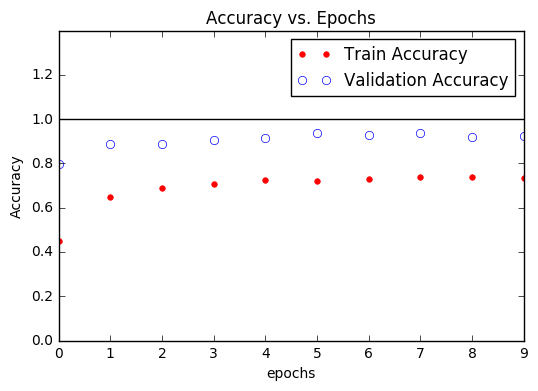

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
df = pd.DataFrame(h.history)
df['epoch'] =df.index

fig = plt.figure(1)
ax = fig.add_subplot(111)

ax.set_ylim(0,1.4)
ax.set_title('Accuracy vs. Epochs')
ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')

line_train, =ax.plot(np.array(df['epoch']), np.array(df['acc']), '.', color='red', markersize=8)
#plt.plot(x=np.array(df['epoch']), y=np.array(df['acc']), style='o', ylim=(0,1.1), markerfacecolor="None", markeredgecolor='red')
line_val, = ax.plot(np.array(df['epoch']), np.array(df['val_acc']), 'o',  markerfacecolor="None", markeredgecolor='blue')
ax.plot(np.array(df['epoch']), np.ones(len(df)), 'black')
ax.legend((line_train, line_val), ('Train Accuracy', 'Validation Accuracy'))
fig.savefig(sub_path + '/train_accuracy_vs_epochs10_base.png')

# Check the effects of Learning Rate

AttributeError: 'Sequential' object has no attribute 'optimizer'

In [105]:
val_data.classes
#val_data.__dict__
val_data.samples

50

In [94]:
import vgg16; reload(vgg16)
#vggm.model.save_weights(sub_path + '/sample_epochs200.h5')
vggm = vgg16.Vgg16()
batch_size = 60
vggm.finetune(train_data)
vggm.model.load_weights(sub_path + '/sample_epochs200.h5')
from sklearn.metrics import confusion_matrix
val_batches, val_predictions = vggm.test(val_path, batch_size)

Found 50 images belonging to 10 classes.


In [99]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint
vggm.model.optimizer.get_config()

{'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-08,
 'lr': 0.0010000000474974513}

In [103]:
epochs = 20
lrs = [1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8]
hs = {}
for lr in lrs:
    print("lr = %s"%lr)
    K.set_value(vggm.model.optimizer.lr, lr)
    saved_weights_path = weight_path + '/sample.lr_%6f_epoch_{epoch:02d}-valloss_{val_loss:.2f}.hdf5'%lr
    print(saved_weights_path)
    mcp = ModelCheckpoint(saved_weights_path, monitor='val_loss', save_weights_only=True, mode='auto', period=20)
    call_backs = [mcp]
    h = vggm.fit(train_data, val_data, nb_epoch=epochs, batch_size = batch_size, callbacks=call_backs)
    hs[lr] = h


lr = 1e-05
/home/ubuntu/data/weights/statefarm//sample.lr_0.000010_epoch_{epoch:02d}-valloss_{val_loss:.2f}.hdf5
Epoch 1/20
2/1 [====================================] - 5s 3s/step - loss: 0.0299 - acc: 1.0000 - val_loss: 1.9741 - val_acc: 0.5400
Epoch 2/20
2/1 [====================================] - 5s 2s/step - loss: 0.0680 - acc: 0.9794 - val_loss: 1.9729 - val_acc: 0.5400
Epoch 3/20
2/1 [====================================] - 5s 2s/step - loss: 0.0774 - acc: 0.9589 - val_loss: 1.9718 - val_acc: 0.5400
Epoch 4/20
2/1 [====================================] - 5s 2s/step - loss: 0.0750 - acc: 0.9644 - val_loss: 1.9707 - val_acc: 0.5400
Epoch 5/20
2/1 [====================================] - 5s 2s/step - loss: 0.0237 - acc: 1.0000 - val_loss: 1.9695 - val_acc: 0.5400
Epoch 6/20
2/1 [====================================] - 5s 2s/step - loss: 0.0552 - acc: 0.9706 - val_loss: 1.9685 - val_acc: 0.5600
Epoch 7/20
2/1 [====================================] - 5s 2s/step - loss: 0.0409 - acc: 

KeyboardInterrupt: 

In [8]:
val_preds = [np.argmax(k) for k in val_predictions]
#print(val_predictions[0])
#print(val_batches.classes)
#print(val_preds)
cnf_matrix = confusion_matrix(val_batches.classes, val_preds)
print(cnf_matrix)
test_batches, predictions = val_batches, val_predictions

[[3 0 0 1 0 0 0 0 1 0]
 [2 3 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 1 0]
 [0 1 0 1 0 0 0 0 3 0]
 [0 0 1 0 3 0 0 0 1 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 1 2 0 1 1]
 [0 1 0 0 0 0 0 3 1 0]
 [0 1 0 0 0 2 0 1 1 0]
 [2 0 0 0 0 0 0 0 0 3]]


# Check examples that predicted good, bad, or neutral

[6, 8, 6, 5, 9, 7, 1, 7, 8, 7]
[6 6 6 6 6 7 7 7 7 7]


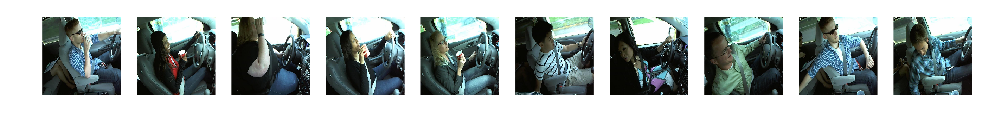

In [10]:
import utils; reload(utils)
from utils import plot, plots, plotgray
val_preds = [np.argmax(k) for k in val_predictions]
plots(next(val_batches)[30:40])
#print((next(val_batches)[0].shape))
print(val_preds[30:40])
print(val_batches.classes[30:40])

In [ ]:
The 10 classes to predict are:

c0: safe driving
c1: texting - right
c2: talking on the phone - right
c3: texting - left
c4: talking on the phone - left
c5: operating the radio
c6: drinking
c7: reaching behind
c8: hair and makeup
c9: talking to passenger


# A few examples of correct predictions with high confidence

[44 21 40 13 43  3 48 17 33 23 12 11 15 38 34  1 31 18 37 26 46 41  0  9 36  6  5 22 49 45 35  4 32
 10 47 27 28  2 19 39 30 20 16  7 29 14  8 42 24 25]
[2, 3, 4, 5, 7, 8, 10, 12, 14, 16, 20, 23, 24, 25, 26, 27, 28, 29, 30, 32, 35, 37, 39, 42, 46, 47, 49]
[14, 8, 42, 24, 25]
Top 5 predicts: [2 1 8 4 5]
True classes: [2 1 8 4 5]
Pictures that we correctly predicted with high confidence


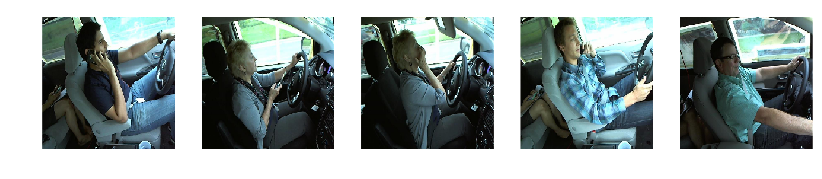

In [64]:
max_val_preds = np.array([max(vp) for vp in val_predictions])
#print(max_val_preds)
sorted_index = np.argsort(max_val_preds) #ascending order
print(sorted_index)
#print(max_val_preds[[44,21,40, 42, 24, 25]])

pairs = zip(val_preds, val_batches.classes)
correct_preds = [idx for idx, m in enumerate(pairs) if m[0]==m[1]] #indexes for correct predictions
incorrect_preds = [idx for idx, m in enumerate(pairs) if m[0]!=m[1]] #indexes for incorrect predictions
print(correct_preds)
top_5_corrects = [si for si in sorted_index[-5:] if si in correct_preds]
print(top_5_corrects)
print("Top 5 correct predicts: %s"%val_preds[top_5_corrects])
print("True classes: %s"%val_batches.classes[top_5_corrects])
print("Pictures that we correctly predicted with high confidence")
plots(next(val_batches)[top_5_corrects])

# A few examples of wrong predictions with high confidence

[0, 1, 6, 9, 11, 13, 15, 17, 18, 19, 21, 22, 31, 33, 34, 36, 38, 40, 41, 43, 44, 45, 48]
[36, 6, 22, 45, 19]
Top 5 incorrect predicts: [1 0 8 0 1]
True classes: [7 1 4 9 3]
Pictures that we Incorrectly predicted with high confidence


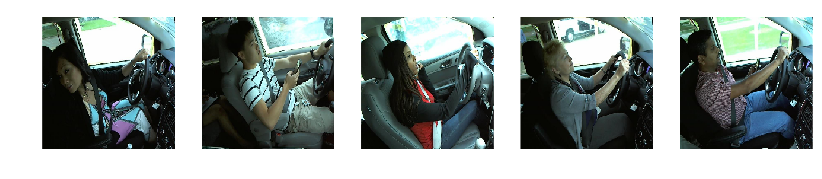

In [70]:
print(incorrect_preds)
top_5_incorrects = [si for si in sorted_index if si in incorrect_preds][-5:]
print(top_5_incorrects)
print("Top 5 incorrect predicts: %s"%val_preds[top_5_incorrects])
print("True classes: %s"%val_batches.classes[top_5_incorrects])
print("Pictures that we Incorrectly predicted with high confidence")
plots(next(val_batches)[top_5_incorrects])

# A Few Random Examples of Correct Predictions

Random 5 correct predicts: [2 9 0 7 0]
True classes: [2 9 0 7 0]
Pictures that we Correctly predicted


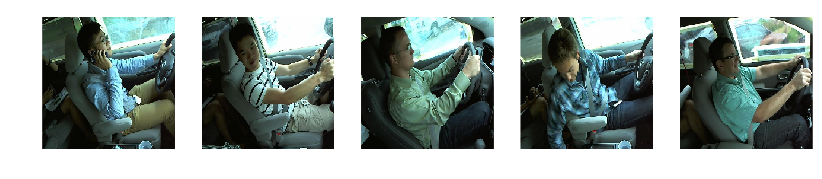

In [73]:
import random
five_corrects = random.sample(correct_preds, 5)
print("Random 5 correct predicts: %s"%val_preds[five_corrects])
print("True classes: %s"%val_batches.classes[five_corrects])
print("Pictures that we Correctly predicted")

plots(next(val_batches)[five_corrects])

# A Few Random Examples of Incorrect Predictions

Random 5 incorrect predicts: [3 1 5 8 8]
True classes: [0 8 8 7 3]
Pictures that we Incorrectly predicted


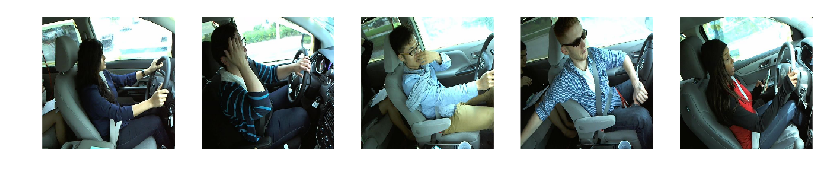

In [74]:
import random
five_incorrects = random.sample(incorrect_preds, 5)
print("Random 5 incorrect predicts: %s"%val_preds[five_incorrects])
print("True classes: %s"%val_batches.classes[five_incorrects])
print("Pictures that we Incorrectly predicted")

plots(next(val_batches)[five_incorrects])

# Examples with probabilities close to each other

Confused indexes: [11, 21, 40, 44]
Confused predictions: [[  3.5329e-05   4.0434e-01   1.4680e-02   1.0490e-03   1.6275e-02   4.9971e-05   1.8890e-03
    2.3638e-04   5.6078e-01   6.5787e-04]
 [  1.3841e-01   3.1891e-04   3.7617e-01   3.7430e-05   2.7578e-01   9.9057e-02   3.1241e-03
    1.0832e-02   5.4598e-02   4.1667e-02]
 [  1.4741e-02   4.2640e-01   1.7430e-02   2.5573e-01   5.2060e-02   5.6424e-02   9.8087e-02
    4.9644e-04   6.7270e-02   1.1363e-02]
 [  6.9515e-03   4.3002e-02   2.2935e-01   4.9439e-04   1.9084e-01   1.4710e-01   1.1928e-01
    2.3950e-01   2.2384e-02   1.0914e-03]]
Confused predicts: [8 2 1 7]
True classes: [2 4 8 8]
Pictures that are confused


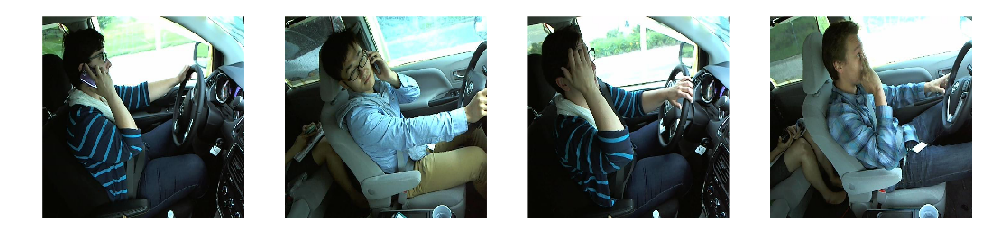

In [87]:
sorted_probs_val_preds = np.array([np.sort(vp) for vp in val_predictions])
#print(val_predictions[:2])
vp = sorted_probs_val_preds[0]
diff_probs_val_preds = [abs(vp[-1]-vp[-2]) for vp in sorted_probs_val_preds]
confused_idx = [idx for idx, p in enumerate(diff_probs_val_preds) if p < 0.2]
print("Confused indexes: %s"%confused_idx)
print("Confused predictions: %s"%val_predictions[confused_idx])
print("Confused predicts: %s"%val_preds[confused_idx])
print("True classes: %s"%val_batches.classes[confused_idx])
print("Pictures that are confused")

plots(next(val_batches)[confused_idx])

In [ ]:
s = test_batches.class_indices.keys()
s.sort()
print(s)
cols = ['img'] + s
print(cols)
dff = pd.DataFrame(predictions, columns=s)
print(dff.head())
print(len(predictions))
print(len(dff))
epochs = 200
print(df.columns.tolist())

In [15]:
test_batches, predictions = vggm.test(test_path, batch_size)

Found 79726 images belonging to 1 classes.


In [24]:
len(test_batches.filenames)

79726

# Create Submission File

In [25]:
def get_id(img_path):
    fid = img_path.split("/")[1] #Get image ID
    return fid

s = train_data.class_indices.keys()
s.sort()
df = pd.DataFrame(predictions, columns=s)
df['img'] = test_batches.filenames
df['img'] = df.apply(lambda r: get_id(r['img']), axis=1)
cols = cols = ['img'] + s
df = df[cols]
#print(df)
fn = "./sub/statefarm/train_batchsize_" + str(batch_size) + "_epochs" + str(epochs) +"_.csv"
df.to_csv(fn, index=False)
print("Write to " + fn)
print("DONE!")
from IPython.display import FileLink
FileLink(fn)  

Write to ./sub/statefarm/train_batchsize_60_epochs10_.csv
DONE!


/home/ubuntu/fastai_course/neilz/part1/sub/statefarm/train_batchsize_60_epochs10_.csv